# Application
In this notebook, we are going to show an application of this dataset. The main idea behind this application is to predict the users' performance tier, which is an internal Kaggle user ranking method, based on the code metrics that each user shows.

## 1. Classification
In the first experiment, we are going with the classification. We will train on 80% of the kernels and predict the performance tier of the author of the other 20% of the kernels. We user `Random Forest` classification method

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import scikitplot as skplt

In [2]:
dataset_path = '../dataset/notebook_metrics.csv'
df = pd.read_csv(dataset_path)
df = df.drop('kernel_id', axis=1)

### Step 1: Handle missing values

In [3]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

### Step 2: Split the dataset into features (X) and target variable (y)

In [4]:
X = df_imputed.drop('PT', axis=1)  # Features
y = df_imputed['PT']  # Target variable

### Step 3: Use RandomUnderSampler to balance the classes and shuffle the dataset

In [5]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

### Step 4: Split the resampled dataset into training and testing sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Step 5: Initialize and train the classifier

In [7]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Step 6: Make predictions on the test set

In [8]:
y_pred = classifier.predict(X_test)

### Step 7: Evaluate the performance of the classifier

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.56
              precision    recall  f1-score   support

         0.0       0.51      0.48      0.49      1537
         1.0       0.37      0.39      0.38      1468
         2.0       0.33      0.37      0.35      1474
         3.0       0.55      0.46      0.50      1470
         4.0       0.62      0.69      0.65      1468
         5.0       1.00      0.98      0.99      1467

    accuracy                           0.56      8884
   macro avg       0.57      0.56      0.56      8884
weighted avg       0.56      0.56      0.56      8884



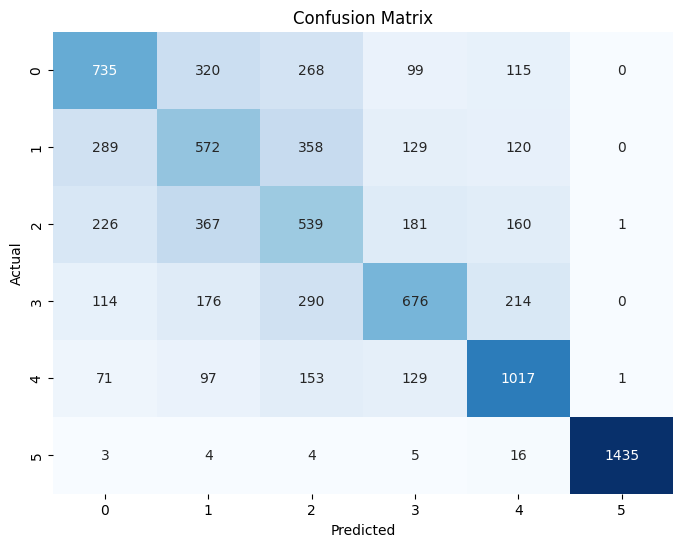

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Step8: Check feature importance and correlation with target variable

In [11]:
feature_importance = pd.Series(classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
 EAP          0.099952
I            0.037969
H2           0.037248
AID          0.033911
AOPERATOR    0.032964
LOC          0.032890
P            0.032707
MeanLCC      0.032612
CW           0.032531
NBD          0.031397
CC           0.030970
KLCID        0.030751
H1           0.030390
CyC          0.030034
MeanLMC      0.029352
ALID         0.029040
ALLC         0.028940
MLID         0.028186
LOPERATOR    0.027290
ID           0.027200
OPRND        0.026809
NEC          0.026519
MW           0.026518
S            0.026271
UOPRND       0.026015
MeanWMC      0.025761
UDF          0.025376
UOPRATOR     0.025022
LOCom        0.024828
LMC          0.022481
MC           0.017432
NVD          0.016656
H3           0.010987
EH           0.002991
BLC          0.000000
dtype: float64


/tmp/ipykernel_1836876/1959196379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")


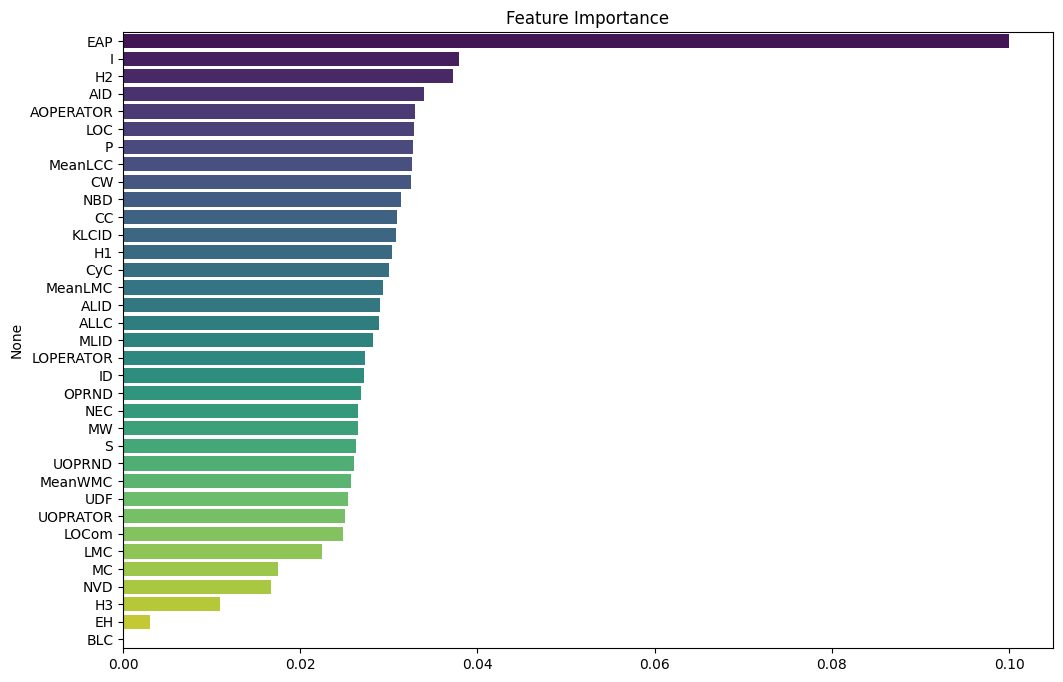

In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title('Feature Importance')
plt.show()

In [13]:
correlation_matrix = df_imputed.corr()
correlation_with_target = correlation_matrix['PT'].sort_values(ascending=False)
print("Correlation with Target Variable:\n", correlation_with_target)

Correlation with Target Variable:
 PT           1.000000
EAP          0.152700
UDF          0.029196
NVD          0.026033
ALID         0.021537
H2           0.016065
MeanWMC      0.015002
LOPERATOR    0.012661
S            0.009552
MLID         0.006264
EH           0.005477
ALLC         0.003319
AID          0.002774
KLCID        0.002501
MeanLCC      0.000714
AOPERATOR   -0.001510
NBD         -0.003098
MeanLMC     -0.010257
UOPRND      -0.011230
OPRND       -0.015721
LMC         -0.018934
ID          -0.019130
CyC         -0.020218
MW          -0.024902
LOC         -0.028705
P           -0.035767
UOPRATOR    -0.037344
LOCom       -0.041904
I           -0.048980
H3          -0.050752
H1          -0.051803
MC          -0.054167
CW          -0.054808
NEC         -0.089654
CC          -0.108685
BLC               NaN
Name: PT, dtype: float64


### Step 9: Do dimensionality reduction and plot

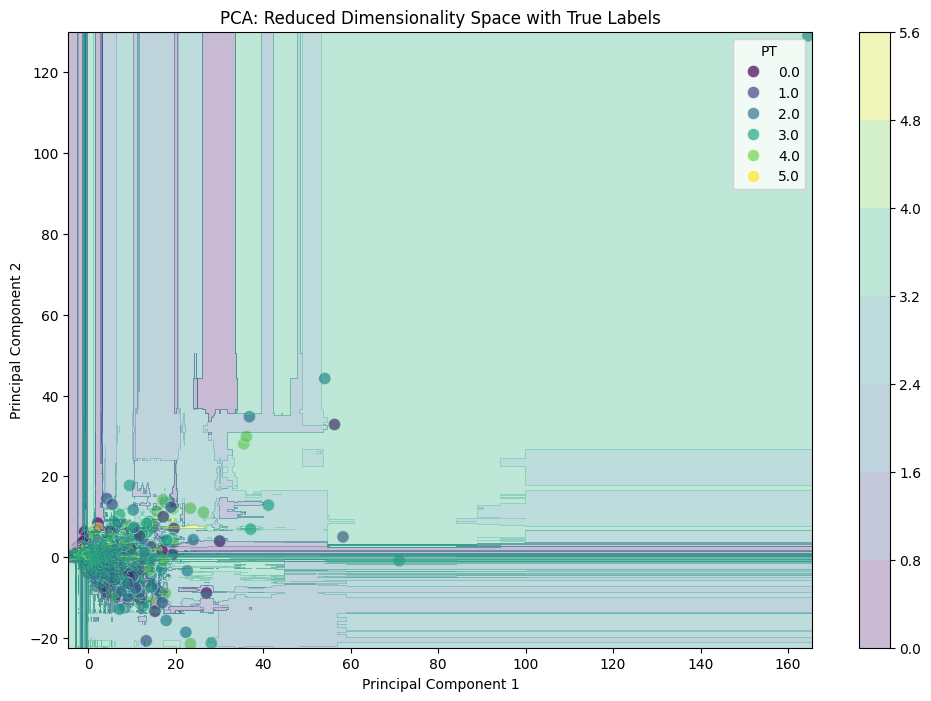

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize and train the classifier
classifier = RandomForestClassifier(random_state=42)  # You can use any other classifier here
classifier.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_pca)

# Plot the dataset in reduced dimensionality space
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='viridis', alpha=0.7, s=80, edgecolor='w')
plt.title('PCA: Reduced Dimensionality Space with True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot decision boundaries
h = .02
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)
plt.colorbar()

plt.show()

## 2. Clustring
Now we are going to examine the possiblity of doing a clustring on the notebook metrics and see how it aligns with the performance tier of its author.

In [15]:
num_clusters = df['PT'].nunique()
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X_train['Cluster'] = kmeans.fit_predict(X_train)
X_test['Cluster'] = kmeans.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


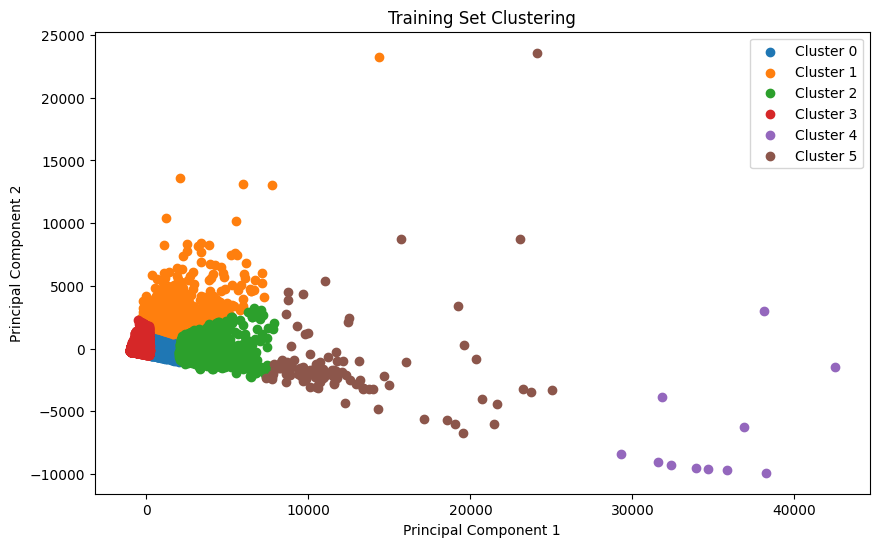

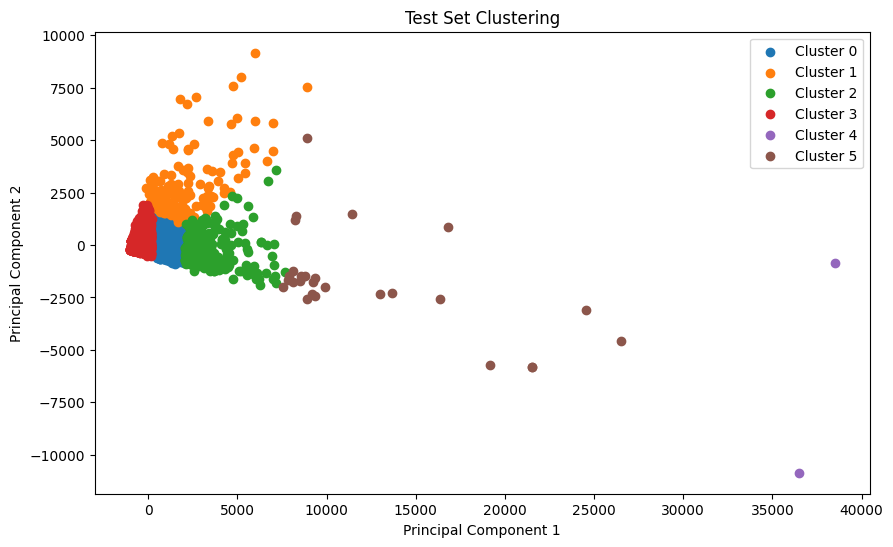

In [16]:
# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot the training set clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_data = X_train_pca[X_train['Cluster'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')

plt.title('Training Set Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Plot the test set clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_data = X_test_pca[X_test['Cluster'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')

plt.title('Test Set Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [17]:
# Calculate the silhouette score for the training set
silhouette_avg_train = silhouette_score(X_train, X_train['Cluster'])

# Calculate the silhouette score for the test set
silhouette_avg_test = silhouette_score(X_test, X_test['Cluster'])

print(f"Silhouette Score (Training Set): {silhouette_avg_train:.4f}")
print(f"Silhouette Score (Test Set): {silhouette_avg_test:.4f}")


Silhouette Score (Training Set): 0.5448
Silhouette Score (Test Set): 0.5342
